In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm

import sys
import os
import glob
import json
import types

In [2]:
#!pip install modeval

In [3]:
# might require sys.insert
#import modeval

In [4]:

def load_results(filename, two_heads=False):
    """Loads conf and results from a file
    Args:
        filename    name of the json/npy file
        two_heads   set up class_output_size if missing
    """
    if filename.endswith(".npy"):
        return np.load(filename, allow_pickle=True).item()

    with open(filename, "r") as f:
        data = json.load(f)

    for key in ["model_type"]:
        if key not in data["conf"]:
            data["conf"][key] = None
    if two_heads and ("class_output_size" not in data["conf"]):
        data["conf"]["class_output_size"] = data["conf"]["output_size"]
        data["conf"]["regr_output_size"]  = 0

    data["conf"] = types.SimpleNamespace(**data["conf"])


    if "results" in data:
        for key in data["results"]:
            data["results"][key] = pd.read_json(data["results"][key])

    if "results_agg" in data:
        for key in data["results_agg"]:
            data["results_agg"][key] = pd.read_json(data["results_agg"][key], typ="series")

    for key in ["training", "validation"]:
        if key not in data:
            continue
        for dfkey in ["classification", "regression"]:
            data[key][dfkey] = pd.read_json(data[key][dfkey])
        for skey in ["classification_agg", "regression_agg"]:
            data[key][skey]  = pd.read_json(data[key][skey], typ="series")

    return data



In [54]:
eval_metric = 'roc_auc_score'
min_samples = 5
avg_perf = 0 
HP_folder = 'HP_scan'
path = f'../../Classification_no_aux/{HP_folder}/Run*/models/'
for file in tqdm(glob.glob(os.path.join(path, '*.json'))):
        res = load_results(file)
        new_avg_perf = np.mean(res['validation']['classification'].query('num_pos>@min_samples and num_neg>@min_samples')[eval_metric])
        if avg_perf < new_avg_perf : 
            avg_perf = new_avg_perf
            best_model = file.split('/')[-3] 
            

100%|██████████| 270/270 [00:04<00:00, 59.07it/s]


In [6]:
avg_perf

0.5854742835012194

In [7]:
avg_perf

0.5854742835012194

In [8]:
avg_perf

0.5854742835012194

In [9]:
best_model

'Run_270_epoch_lr_step_20_10_drop_0.0_size_1253434'

In [64]:
## AUC 

In [57]:
eval_metric = 'roc_auc_score'
min_samples = 5
avg_perf = 0 

for file in tqdm(glob.glob(os.path.join(path, '*.json'))):
        res = load_results(file)
        new_avg_perf = np.mean(res['validation']['classification_agg'][eval_metric])
        if avg_perf < new_avg_perf : 
            avg_perf = new_avg_perf
            best_model = file.split('/')[-3] 

100%|██████████| 270/270 [00:04<00:00, 67.26it/s]


In [29]:
avg_perf

0.6025961974

In [20]:
avg_perf

0.6032526632

In [10]:
avg_perf

0.6499668838

In [28]:
best_model

'Run_095_epoch_lr_step_10_5_drop_0.6_size_1000'

In [58]:
results_best = load_results(f'../../Classification_no_aux/{HP_folder}/{best_model}/models/classification_image_based.json')


minmax
Run_270_epoch_lr_step_20_10_drop_0.0_size_1253434
0.5854742835012194
212
114


<AxesSubplot:>

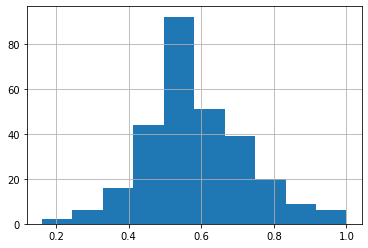

In [44]:
print(best_model)
print(avg_perf)
print(sum(results_best['validation']['classification']['roc_auc_score']>0.5))
print(sum(results_best['validation']['classification']['roc_auc_score']>0.6))
results_best['validation']['classification']['roc_auc_score'].hist()